# Change Point


In [2]:
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
import numpy as np
import math

import sys
import os

# 1. Lấy đường dẫn của thư mục 'Notebook'
current_dir = os.getcwd() 

# 2. Lấy đường dẫn của thư mục Project_Root (Thư mục cha của 'Notebook' và 'Module')
# Đây là thư mục Project_Root/
project_root_dir = os.path.dirname(current_dir)

# 3. Thêm Project_Root vào sys.path
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)
    
print(f"Đã thêm đường dẫn gốc: {project_root_dir}")

# Lệnh import này sẽ hoạt động sau khi thêm Project_Root vào sys.path
from Module.Load_Data import DataLoader, CleanDataLoader
from Module.Processor_Data import DataProcessor
from Module.Analysis import Analysis
from Module.ANOVA_ttest import ANOVA_ttest
from Module.ChangePoint import ChangePointPreparer
from Module.ChangePointDetector import ChangePointDetector

Đã thêm đường dẫn gốc: c:\Users\ADMIN\Documents\PythonProject


In [3]:
import pandas as pd
import numpy as np

# Lưu ý: Class này sẽ hoạt động khi được gọi từ Notebook đã setup đường dẫn
# Nên ta vẫn import từ 'Module' bình thường.
try:
    from Module.Load_Data import CleanDataLoader
except ImportError:
    # Fallback cho trường hợp IDE báo lỗi đỏ (không ảnh hưởng khi chạy thật từ Notebook)
    import sys
    import os
    sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
    from Module.Load_Data import CleanDataLoader

class ChangePointPreparer:
    """
    Chuẩn bị dữ liệu cho bài toán Change Point Detection.
    """
    def __init__(self, clean_loader: CleanDataLoader):
        self.loader = clean_loader

    def _transform_to_timeseries(self, df: pd.DataFrame, series_id: str, metric: str = "mean") -> pd.DataFrame:
        if df is None or df.empty:
            return pd.DataFrame()
        
        # Kiểm tra cột metric
        if metric not in df.columns:
            # Fallback: lấy cột số đầu tiên không phải nam_hoc
            numeric_cols = df.select_dtypes(include=np.number).columns.difference(['nam_hoc'])
            if len(numeric_cols) > 0:
                metric = numeric_cols[0]
            else:
                return pd.DataFrame()
            
        df_out = df[["nam_hoc", metric]].copy()
        df_out.columns = ["year", "value"]
        df_out["series_id"] = series_id
        return df_out[["year", "series_id", "value"]].sort_values("year").reset_index(drop=True)

    def get_subject_series(self, subjects: list[str], metric: str = "mean") -> pd.DataFrame:
        results = []
        for subj in subjects:
            try:
                df = self.loader.get_subject_data(subject=subj, kind="analysis")
                ts = self._transform_to_timeseries(df, series_id=subj, metric=metric)
                results.append(ts)
            except Exception:
                continue
        return pd.concat(results, ignore_index=True) if results else pd.DataFrame(columns=["year", "series_id", "value"])

    def get_block_series(self, blocks: list[str], metric: str = "mean") -> pd.DataFrame:
        results = []
        for blk in blocks:
            try:
                df = self.loader.get_block_data(block=blk, kind="analysis")
                ts = self._transform_to_timeseries(df, series_id=blk, metric=metric)
                results.append(ts)
            except Exception:
                continue
        return pd.concat(results, ignore_index=True) if results else pd.DataFrame(columns=["year", "series_id", "value"])

    def get_province_series(self, provinces: list[str], metric: str = "mean") -> pd.DataFrame:
        results = []
        for prov in provinces:
            try:
                df = self.loader.get_province_data(province=prov, kind="analysis")
                ts = self._transform_to_timeseries(df, series_id=prov, metric=metric)
                results.append(ts)
            except Exception:
                continue
        return pd.concat(results, ignore_index=True) if results else pd.DataFrame(columns=["year", "series_id", "value"])

## 1. Data


<!-- – Từ Subject_Data, Block_Data, Province_Data tạo các chuỗi thời gian ngắn
(2023–2025):
* xmon,year: mean điểm theo môn.
* xblock,year: mean/tổng điểm theo khối.
* xprovince,year: mean tổng điểm theo tỉnh/thành.
– Chuẩn hoá thành các DataFrame dạng:
year, series_id, value
để dễ dàng áp dụng nhiều thuật toán change point trên cùng một cấu trúc. -->



In [4]:
# – Từ Subject_Data, Block_Data, Province_Data tạo các chuỗi thời gian ngắn
# (2023–2025):
# * xmon,year: mean điểm theo môn.
# * xblock,year: mean/tổng điểm theo khối.
# * xprovince,year: mean tổng điểm theo tỉnh/thành.
# – Chuẩn hoá thành các DataFrame dạng:
# year, series_id, value
# để dễ dàng áp dụng nhiều thuật toán change point trên cùng một cấu trúc


# Ví dụ sử dụng:
change_point_preparer = ChangePointPreparer(clean_loader=CleanDataLoader())
subjects = ["Toan", "Van", "Anh"]
subject_series = change_point_preparer.get_subject_series(subjects, metric="mean")
blocks = ["A00", "A01", "B00"]
block_series = change_point_preparer.get_block_series(blocks, metric="mean")
provinces = ["HaNoi", "ThanhphoHoChiMinh", "ĐaNang"]
province_series = change_point_preparer.get_province_series(provinces, metric="mean")

print(subject_series)
print(block_series)
print(province_series)

   year series_id     value
0  2023      Toan  6.250557
1  2024      Toan  6.447309
2  2025      Toan  4.799712
   year series_id      value
0  2023       A00  20.774499
1  2024       A00  20.904633
2  2025       A00  19.384368
3  2023       A01  20.275288
4  2024       A01  20.473793
5  2025       A01  18.878852
6  2023       B00  20.604733
7  2024       B00  20.531107
8  2025       B00  18.340640
   year          series_id      value
0  2023              HaNoi  37.324483
1  2024              HaNoi  39.081294
2  2025              HaNoi  25.724696
3  2023  ThanhphoHoChiMinh  38.174897
4  2024  ThanhphoHoChiMinh  38.443969
5  2025  ThanhphoHoChiMinh  25.010852
6  2023             ĐaNang  35.831963
7  2024             ĐaNang  36.787461
8  2025             ĐaNang  23.185056


Kết quả PELT:


,series_id,algorithm,detected_years,hit_target,hit_year
0,Toan,Ruptures_pelt_l1,[],False,None


Kết quả CUSUM:


,series_id,algorithm,detected_years,hit_target,hit_year,cusum_values
0,Toan,CUSUM_Mean,[2024],True,2024,"[0.41803116758546555, 1.0328141472484198, 0.0]"


Error Ruptures Toan: 


,series_id,algorithm,detected_years,hit_target,hit_year,cusum_values
2,Toan,CUSUM_Mean,[2024],True,2024,"[0.41803116758546555, 1.0328141472484198, 0.0]"


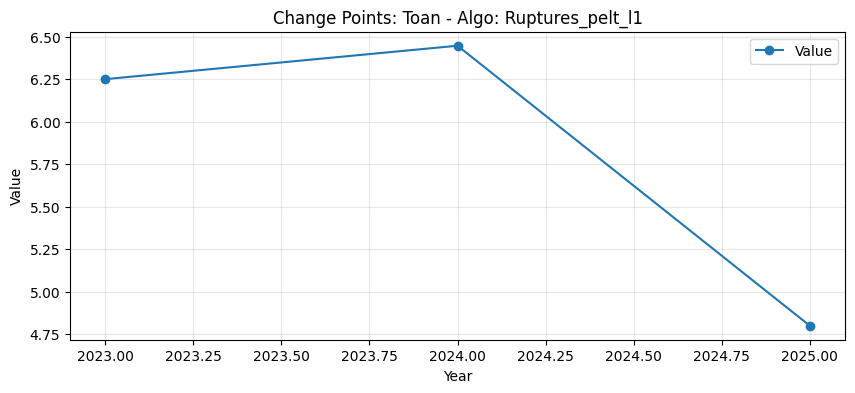

In [15]:
## ChangePointDetector ví dụ sử dụng:
# 1. Chuẩn bị dữ liệu
preparer = ChangePointPreparer(clean_loader=CleanDataLoader()) # clean_loader đã có từ trước
df_subjects = preparer.get_subject_series(["Toan", "Van", "Anh"], metric="mean")

# 2. Khởi tạo bộ phát hiện (Kiểm tra xem có biến động quanh năm 2024-2026 không)
detector = ChangePointDetector(df_subjects, target_year=2025, tolerance=1)

# 3. Chạy từng thuật toán riêng lẻ (để tinh chỉnh tham số)
# Ví dụ: PELT với L2 cost
# Giảm pen từ 10 xuống 1 hoặc 2
df_pelt = detector.detect_ruptures(method="pelt", model="l1", pen=1)
print("Kết quả PELT:")
display(df_pelt)

# Ví dụ: CUSUM
df_cusum = detector.detect_cusum()
print("Kết quả CUSUM:")
display(df_cusum)

# 4. Chạy tổng hợp tất cả
all_results = detector.analyze_all()

# Lọc ra các series có điểm gãy trùng khớp giả thuyết 2025
hits = all_results[all_results['hit_target'] == True]
display(hits)

# 5. Vẽ hình minh họa cho một kết quả cụ thể
if not df_pelt.empty:
    sample = df_pelt.iloc[0]
    detector.plot_series_with_cp(
        series_id=sample['series_id'], 
        algorithm=sample['algorithm'], 
        detected_years=sample['detected_years']
    )


## 2. Change Point Detection

## 3. Comparison of Methods

## 4. Visualization